## Start with writing something

* Input: BTC/USDC trading pair
* Output: Buy/Sell Signal
* Algo: Simple Moving Average (SMA)

Note:
* trade once per day
* use close price to calculate ma
* fast-sma > slow-sma = buy btc
* fast-sma < slow-sma = sell btc




## Demo photo for moving average

![](http://assets.chandoo.org/img/n/calculate-moving-average.png)



In [30]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CoinAPI details
API_KEY = '55144C52-5186-494D-8846-941B30A2CAAA'
BASE_URL = 'https://rest.coinapi.io/v1/'

# Trading parameters
symbol = 'BTC/USDC'
fast_window = 10  # Short-term moving average
slow_window = 50  # Long-term moving average

def get_historical_data(symbol, start_date, end_date):
    headers = {'X-CoinAPI-Key': API_KEY}
    url = f"{BASE_URL}ohlcv/BINANCE_SPOT_{symbol.replace('/', '_')}/history?period_id=1DAY&time_start={start_date}&time_end={end_date}"
    response = requests.get(url, headers=headers)
    data = response.json()
    if response.status_code == 200:
        return pd.DataFrame(data)
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None



In [35]:
start_date = '2023-01-01'
end_date = '2024-01-01'
input_data = get_historical_data(symbol, start_date, end_date)
df = input_data
print(df.head())

              time_period_start               time_period_end  \
0  2023-03-12T00:00:00.0000000Z  2023-03-13T00:00:00.0000000Z   
1  2023-03-13T00:00:00.0000000Z  2023-03-14T00:00:00.0000000Z   
2  2023-03-14T00:00:00.0000000Z  2023-03-15T00:00:00.0000000Z   
3  2023-03-15T00:00:00.0000000Z  2023-03-16T00:00:00.0000000Z   
4  2023-03-16T00:00:00.0000000Z  2023-03-17T00:00:00.0000000Z   

                      time_open                    time_close  price_open  \
0  2023-03-12T06:30:00.0000000Z  2023-03-12T23:59:59.6710000Z    20632.41   
1  2023-03-13T00:00:00.0320000Z  2023-03-13T23:59:42.8610000Z    22333.49   
2  2023-03-14T00:00:06.3330000Z  2023-03-14T23:59:03.5060000Z    24242.34   
3  2023-03-15T00:00:04.9890000Z  2023-03-15T23:59:55.1770000Z    24768.91   
4  2023-03-16T00:00:00.2020000Z  2023-03-16T23:59:53.3150000Z    24374.81   

   price_high  price_low  price_close  volume_traded  trades_count  
0    50000.00   20632.41     22333.49     4318.34950        130167  
1    247

In [17]:
def preprocess_data(df):
    df['time_period_start'] = pd.to_datetime(df['time_period_start'])
    df.set_index('time_period_start', inplace=True)
    df['price_close'] = df['price_close'].astype(float)
    return df

def backtest_strategy(df):
    # Calculate the SMAs
    df['fast_sma'] = df['price_close'].rolling(window=fast_window, min_periods=1).mean() # 10 days short-term
    df['slow_sma'] = df['price_close'].rolling(window=slow_window, min_periods=1).mean() # 50 days long-term

    # Generate signals: 1 for buy, -1 for sell
    df['position'] = 0 # hold
    df['position'] = np.where(df['fast_sma'] > df['slow_sma'], 1, 0) # buy btc sell usdc
    df['position'] = np.where(df['fast_sma'] < df['slow_sma'], -1, df['position']) # sell btc buy usdc

    # Shift position column to align with future returns
    df['position'] = df['position'].shift(1).fillna(0)

    # Calculate returns
    df['returns'] = df['price_close'].pct_change()
    df['strategy_returns'] = df['position'] * df['returns']
    df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

    return df





In [18]:
print(df.head)
df = preprocess_data(df)
print(df)
df = backtest_strategy(df)
print(df)

<bound method NDFrame.head of                time_period_start               time_period_end  \
0   2023-03-12T00:00:00.0000000Z  2023-03-13T00:00:00.0000000Z   
1   2023-03-13T00:00:00.0000000Z  2023-03-14T00:00:00.0000000Z   
2   2023-03-14T00:00:00.0000000Z  2023-03-15T00:00:00.0000000Z   
3   2023-03-15T00:00:00.0000000Z  2023-03-16T00:00:00.0000000Z   
4   2023-03-16T00:00:00.0000000Z  2023-03-17T00:00:00.0000000Z   
5   2023-03-17T00:00:00.0000000Z  2023-03-18T00:00:00.0000000Z   
6   2023-03-18T00:00:00.0000000Z  2023-03-19T00:00:00.0000000Z   
7   2023-03-19T00:00:00.0000000Z  2023-03-20T00:00:00.0000000Z   
8   2023-03-20T00:00:00.0000000Z  2023-03-21T00:00:00.0000000Z   
9   2023-03-21T00:00:00.0000000Z  2023-03-22T00:00:00.0000000Z   
10  2023-03-22T00:00:00.0000000Z  2023-03-23T00:00:00.0000000Z   
11  2023-03-23T00:00:00.0000000Z  2023-03-24T00:00:00.0000000Z   
12  2023-03-24T00:00:00.0000000Z  2023-03-25T00:00:00.0000000Z   
13  2023-03-25T00:00:00.0000000Z  2023-03-26T0

In [19]:
def plot_results(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['price_close'], label='BTC/USDC Price')
    plt.plot(df['fast_sma'], label=f'{fast_window}-Day SMA', linestyle='--')
    plt.plot(df['slow_sma'], label=f'{slow_window}-Day SMA', linestyle='--')
    plt.title('BTC/USDC Price and SMA Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price (USDC)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['cumulative_returns'], label='Cumulative Returns')
    plt.title('Strategy Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

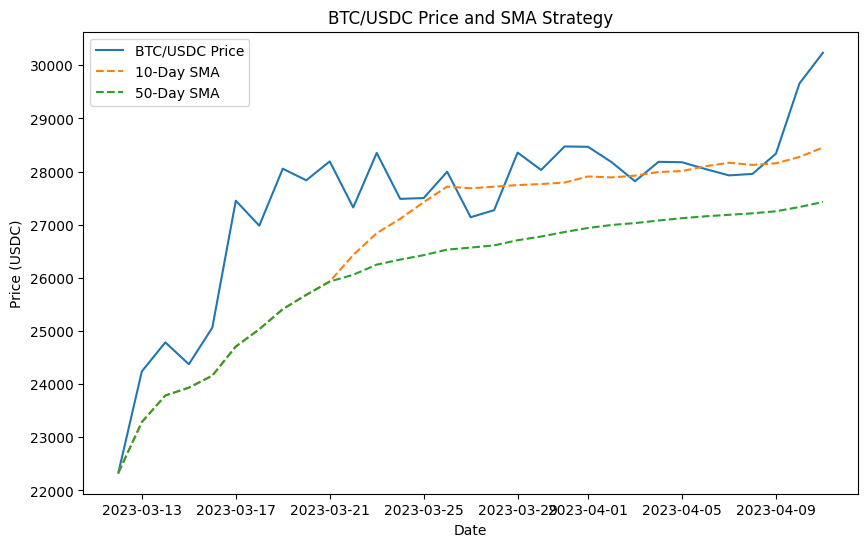

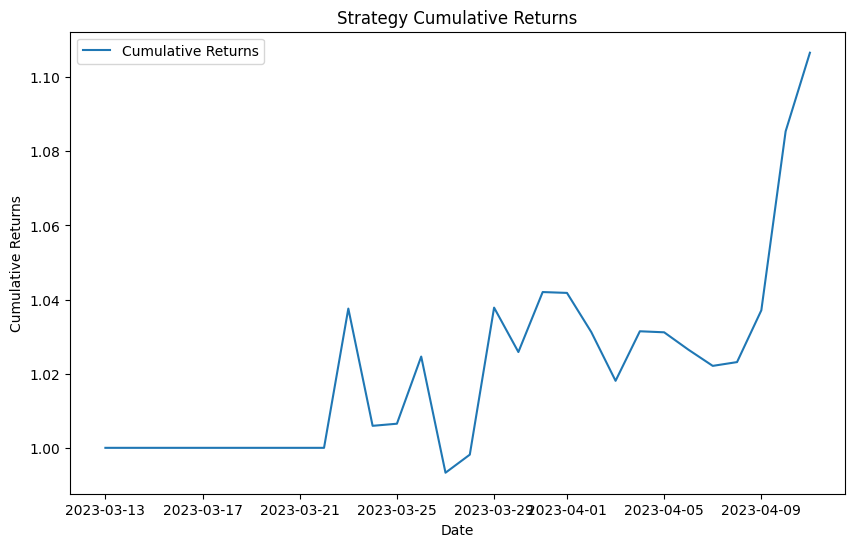

In [20]:
plot_results(df)

## What about AI

Can we apply AI to the problem?

So the input and output can stay the same, while we use deep learning to find some signals

* Input: BTC/USDC trading pair
* Output: Buy/Sell Signal
* Algo: A supervised learning CNN networks


Note:
* trade once per day

In [23]:
print(input_data.head())

                                        time_period_end  \
time_period_start                                         
2023-03-12 00:00:00+00:00  2023-03-13T00:00:00.0000000Z   
2023-03-13 00:00:00+00:00  2023-03-14T00:00:00.0000000Z   
2023-03-14 00:00:00+00:00  2023-03-15T00:00:00.0000000Z   
2023-03-15 00:00:00+00:00  2023-03-16T00:00:00.0000000Z   
2023-03-16 00:00:00+00:00  2023-03-17T00:00:00.0000000Z   

                                              time_open  \
time_period_start                                         
2023-03-12 00:00:00+00:00  2023-03-12T06:30:00.0000000Z   
2023-03-13 00:00:00+00:00  2023-03-13T00:00:00.0320000Z   
2023-03-14 00:00:00+00:00  2023-03-14T00:00:06.3330000Z   
2023-03-15 00:00:00+00:00  2023-03-15T00:00:04.9890000Z   
2023-03-16 00:00:00+00:00  2023-03-16T00:00:00.2020000Z   

                                             time_close  price_open  \
time_period_start                                                     
2023-03-12 00:00:00+00:00  202

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 3, 16)  # Adjust based on sequence length
        self.fc2 = nn.Linear(16, 2)  # Output layer with 2 neurons for BTC and USDC

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=1)  # Softmax activation to get portfolio weights



# Preprocess the data
def preprocess_data(df):
    df['time_period_start'] = pd.to_datetime(df['time_period_start'])
    df.set_index('time_period_start', inplace=True)
    df = df[['price_close', 'price_high', 'price_low']].astype(float)

    # Normalize prices by the last closing price
    last_close = df['price_close'].iloc[-1]
    df['price_close'] /= last_close
    df['price_high'] /= last_close
    df['price_low'] /= last_close

    return df

# Convert the DataFrame to sequences suitable for the model
def create_sequences(df, seq_length):
    sequences = []
    if len(df) < seq_length:
        print("Not enough data to create sequences. Reduce the sequence length or get more data.")
        return np.array(sequences)  # Return an empty array if not enough data

    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values.T  # Transpose for PyTorch (channels, sequence length)
        sequences.append(seq)
    return np.array(sequences)

In [51]:
# Function to generate weights for each step using the trained model
def generate_weights_for_each_step(df, model, seq_length):
    btc_weights = []
    usdc_weights = []

    # Iterate over the data using a sliding window
    for i in range(seq_length, len(df)):
        # Create the input tensor for the current window
        current_sequence = torch.tensor(df[['price_high', 'price_low', 'price_close']].iloc[i-seq_length:i].values.T, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 3, seq_length)
        # Get the predicted weights
        btc_weight, usdc_weight = generate_signal(current_sequence)
        btc_weights.append(btc_weight)
        usdc_weights.append(usdc_weight)

    # Create a DataFrame to store the weights with the corresponding dates
    weights_df = pd.DataFrame({
        'btc_weight': btc_weights,
        'usdc_weight': usdc_weights
    }, index=df.index[seq_length:])

    return weights_df

# Function to generate the portfolio weights using the model
def generate_signal(current_price_tensor):
    model.eval()
    with torch.no_grad():
        predicted_weights = model(current_price_tensor).squeeze(0).numpy()
        btc_weight = predicted_weights[0]
        usdc_weight = predicted_weights[1]
        return btc_weight, usdc_weight

In [54]:
input_data = get_historical_data(symbol, start_date, end_date)
df = preprocess_data(input_data)
print(df.head())

# Create sequences for the model
seq_length = 5  # Number of periods for each sequence
sequences = create_sequences(df, seq_length)
# Convert sequences to PyTorch tensors
X_train = torch.tensor(sequences, dtype=torch.float32)

# For simplicity, let's create random target weights as an example
y_train = torch.rand((X_train.shape[0], 2), dtype=torch.float32)  # Random weights for BTC and USDC

# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Generate portfolio weights for each time step
weights_df = generate_weights_for_each_step(df, model, seq_length)

# Print the weights for verification
print(weights_df.head())

                           price_close  price_high  price_low
time_period_start                                            
2023-03-12 00:00:00+00:00     0.738624    1.653625   0.682365
2023-03-13 00:00:00+00:00     0.801721    0.817355   0.721013
2023-03-14 00:00:00+00:00     0.819741    0.876994   0.797188
2023-03-15 00:00:00+00:00     0.806136    0.836679   0.792086
2023-03-16 00:00:00+00:00     0.828896    0.834420   0.800543
Epoch [1/20], Loss: 0.0844
Epoch [2/20], Loss: 0.0842
Epoch [3/20], Loss: 0.0841
Epoch [4/20], Loss: 0.0839
Epoch [5/20], Loss: 0.0838
Epoch [6/20], Loss: 0.0837
Epoch [7/20], Loss: 0.0836
Epoch [8/20], Loss: 0.0835
Epoch [9/20], Loss: 0.0834
Epoch [10/20], Loss: 0.0834
Epoch [11/20], Loss: 0.0834
Epoch [12/20], Loss: 0.0834
Epoch [13/20], Loss: 0.0834
Epoch [14/20], Loss: 0.0834
Epoch [15/20], Loss: 0.0834
Epoch [16/20], Loss: 0.0834
Epoch [17/20], Loss: 0.0834
Epoch [18/20], Loss: 0.0833
Epoch [19/20], Loss: 0.0833
Epoch [20/20], Loss: 0.0833
               

<ipython-input-55-1de3d449d5ec>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  weights_df['cumulative_returns'].iloc[0] = 1  # Set the first value to 1 explicitly
<ipython-input-55-1de3d449d5ec>:21: SettingWithCopyWarning: 
A value is try

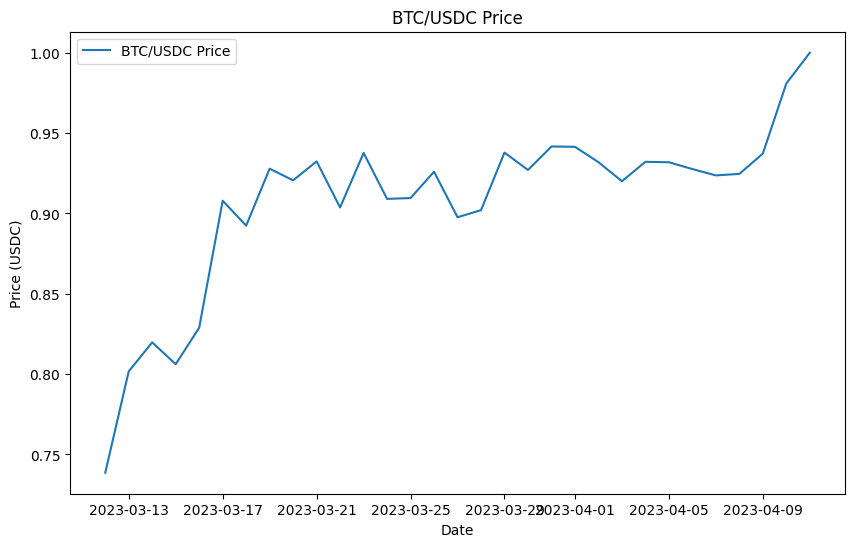

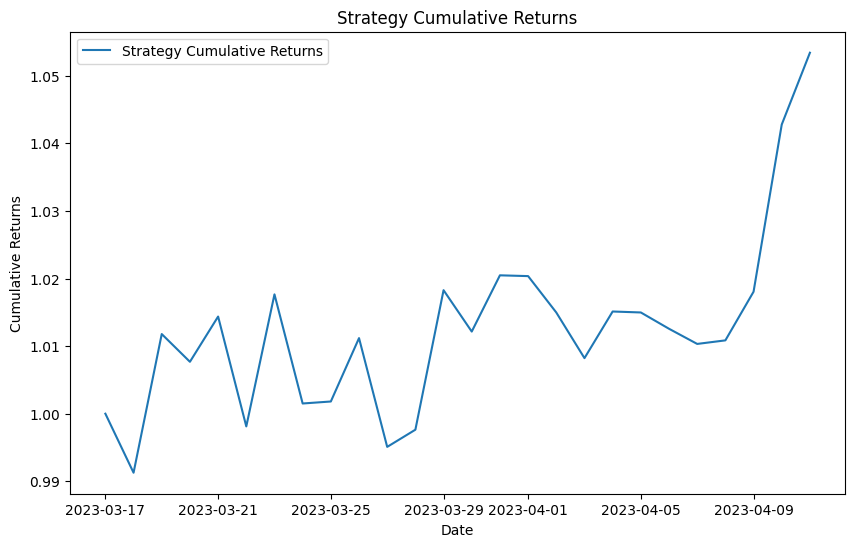

In [55]:
# Function to calculate portfolio returns based on model predictions
def calculate_returns(df, model, seq_length):
    btc_weights = []
    usdc_weights = []

    for i in range(seq_length, len(df)):
        current_sequence = torch.tensor(df.iloc[i-seq_length:i].values.T, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 3, seq_length)
        btc_weight, usdc_weight = generate_signal(current_sequence)
        btc_weights.append(btc_weight)
        usdc_weights.append(usdc_weight)

    # Convert weights to a DataFrame
    weights_df = pd.DataFrame({'btc_weight': btc_weights, 'usdc_weight': usdc_weights}, index=df.index[seq_length:])

    # Calculate daily returns based on BTC weights
    df['returns'] = df['price_close'].pct_change()
    weights_df['strategy_returns'] = weights_df['btc_weight'].shift(1) * df['returns'].iloc[seq_length:]

    # Initialize cumulative returns starting at 1
    weights_df['cumulative_returns'] = (1 + weights_df['strategy_returns']).cumprod()
    weights_df['cumulative_returns'].iloc[0] = 1  # Set the first value to 1 explicitly

    return weights_df


# Plotting function
def plot_strategy_results(df, weights_df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['price_close'], label='BTC/USDC Price')
    plt.title('BTC/USDC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USDC)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(weights_df['cumulative_returns'], label='Strategy Cumulative Returns')
    plt.title('Strategy Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()



# Calculate the returns and cumulative returns using the trained model
weights_df = calculate_returns(df, model, seq_length)

# Plot the results
plot_strategy_results(df, weights_df)

## Risk Management

In [56]:

def calculate_performance_metrics(weights_df):
    # Assuming daily returns are already calculated in 'strategy_returns'
    returns = weights_df['strategy_returns'].dropna()

    # Sharpe Ratio Calculation
    risk_free_rate = 0.0  # Assuming a risk-free rate of 0 for simplicity
    sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std()

    # Sortino Ratio Calculation
    downside_returns = returns[returns < 0]
    sortino_ratio = (returns.mean() - risk_free_rate) / downside_returns.std()

    # Max Drawdown Calculation
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return sharpe_ratio, sortino_ratio, max_drawdown

# Calculate the metrics
sharpe_ratio, sortino_ratio, max_drawdown = calculate_performance_metrics(weights_df)

# Print the results
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4%}")

Sharpe Ratio: 0.1889
Sortino Ratio: 0.3585
Max Drawdown: -2.2170%
